In [1]:
%matplotlib notebook
import matplotlib as mpl
from matplotlib import pyplot as plt
#from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams['font.family'] = "serif"
from matplotlib.animation import FuncAnimation

import numpy as np
from netCDF4 import Dataset
import sys, time, os
for pap in ["/home/lahaye/"+pa for pa in ["Coding/Python_ROMS_Modules/lahaye"]]:
    if pap not in sys.path: sys.path.append(pap)
import comp_zlevs as zlev
import gsw

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = "/net/ruchba/local/tmp/2/lahaye/"

In [2]:
# useful functions
def symlog(x, a): 
    return np.where(np.log10(abs(x))>=a, np.log10(abs(x))-a, np.nan)*np.sign(x)

In [30]:
simul = "luckyt"

if simul =="luckyto":
    its = 1000, 1080
else:
    its = None,None
    #raise ValueError('simul {} unknown'.format(simul))
    
path_col = RUCHBA+"moorings_from_simus/{}_column_i1027_j0968.nc".format(simul)
#path_grd = KRYPTON+"lucky_corgrd.nc"


In [4]:
# load data
nc = Dataset(path_col, "r")
ncvar = nc.variables
xi = ncvar["xi_rho"][:]
eta = ncvar["eta_rho"][:]
times = ncvar["time"][:]
indt, = np.where( (times>=its[0]) & (times<its[1]) )
pm = ncvar['pm'][:]
pn = ncvar['pn'][:]
lon = ncvar['lon_rho'][:]
lat = ncvar['lat_rho'][:]
topo = ncvar['topo'][:]
zrb = ncvar['zrb'][:]
dz = np.diff(ncvar["zwb"][:],axis=0)
ked = ncvar['ke_diss'][indt,...]
print(nc.variables)
nc.close()

Nt, Nz, Ny, Nx = ked.shape
times = times[indt]
dt = np.diff(times)[0]
dv_cell = dz/pm[None,...]/pn[None,...]


OrderedDict([('xi_rho', <class 'netCDF4._netCDF4.Variable'>
int16 xi_rho(xi_rho)
unlimited dimensions: 
current shape = (5,)
filling on, default _FillValue of -32767 used
), ('eta_rho', <class 'netCDF4._netCDF4.Variable'>
int16 eta_rho(eta_rho)
unlimited dimensions: 
current shape = (5,)
filling on, default _FillValue of -32767 used
), ('s_rho', <class 'netCDF4._netCDF4.Variable'>
int16 s_rho(s_rho)
unlimited dimensions: 
current shape = (80,)
filling on, default _FillValue of -32767 used
), ('s_w', <class 'netCDF4._netCDF4.Variable'>
int16 s_w(s_w)
unlimited dimensions: 
current shape = (81,)
filling on, default _FillValue of -32767 used
), ('time', <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
unlimited dimensions: time
current shape = (1084,)
filling on, default _FillValue of -2147483647 used
), ('scrum_time', <class 'netCDF4._netCDF4.Variable'>
float32 scrum_time(time)
    longname: ocean time
    units: h
unlimited dimensions: time
current shape = (1084,)
filling on, defaul

<IPython.core.display.Javascript object>


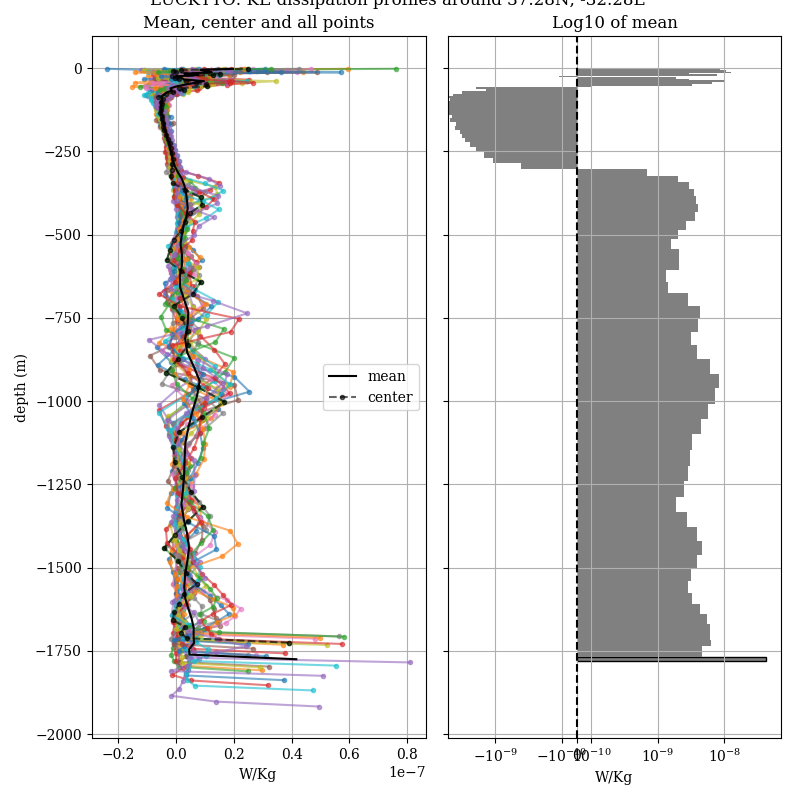

In [5]:
# visualize vertical profiles (time average, all pos. and mean)

j0, i0 = Ny//2, Nx//2

diss = -ked.mean(axis=0)/dv_cell
diss_mean = diss.mean(axis=(1,2))
zrm = zrb.mean(axis=(1,2))
dzm = dz.mean(axis=(1,2))

fig, axs = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(8,8))

ax = axs[0]
ax.plot(diss.reshape(Nz,-1), zrb.reshape(Nz,-1), '.-', alpha=.6)
ax.plot(diss_mean, zrm, "k", label="mean")
ax.plot(diss[:,j0,i0], zrb[:,j0,i0], ".--k" \
                                                , alpha=.6, label="center")
ax.legend(loc="center right")
ax.set_title("Mean, center and all points")
ax.set_ylabel('depth (m)')

ax = axs[1]
ax.barh(zrm, diss_mean, dzm, facecolor="grey", edgecolor="k")
ax.set_xscale("symlog", linthreshx=1e-10, linscalex=.2)
ax.axvline(0, color="k", lw=1.5, linestyle="--")
ax.set_title('Log10 of mean')
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('W/Kg')

fig.set_tight_layout(True)
fig.suptitle(simul.upper()+": KE dissipation profiles around {0:.2f}N, {1:.2f}E "\
                             .format(lat[j0,i0],lon[j0,i0]), y=1.01)

if False:#dosavefig:
    plt.savefig("pictures/{0}_KEdiss-prof_j{1:04d}_i{2:04d}.pdf".format(simul\
                        ,j0,i0), magnification="auto", bbox_inches="tight", dpi=200)

<IPython.core.display.Javascript object>


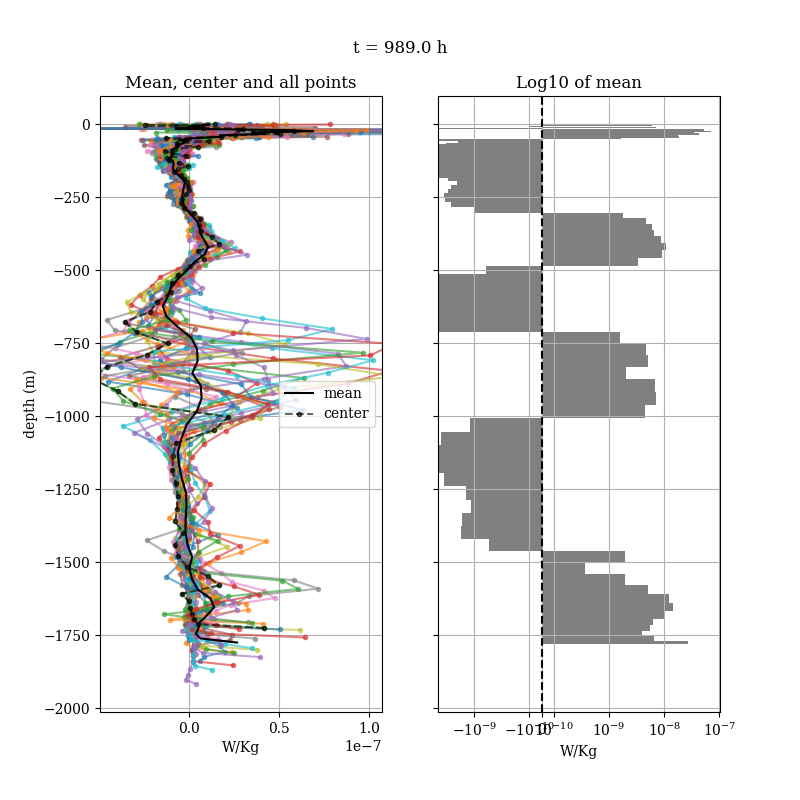

In [39]:
# Animated plot, youhou !

j0, i0 = Ny//2, Nx//2
ix, jx = None, None

diss = -ked.mean(axis=0)/dv_cell
diss_mean = diss.mean(axis=(1,2))
zrm = zrb.mean(axis=(1,2))
dzm = dz.mean(axis=(1,2))

fig, axs = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(8,8))

ax = axs[0]
hl1 = ax.plot(diss.reshape(Nz,-1), zrb.reshape(Nz,-1), '.-', alpha=.6)
hl2, = ax.plot(diss_mean, zrm, "k", label="mean")
hl3, = ax.plot(diss[:,j0,i0], zrb[:,j0,i0], ".--k" \
                                                , alpha=.6, label="center")
ax.legend(loc="center right")
ax.set_title("Mean, center and all points")
ax.set_ylabel('depth (m)')

ax = axs[1]
hb1 = ax.barh(zrm, diss_mean, dzm, facecolor="grey")
ax.set_xscale("symlog", linthreshx=1e-10, linscalex=.2)
ax.axvline(0, color="k", lw=1.5, linestyle="--")
ax.set_title('Log10 of mean')
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('W/Kg')

#fig.set_tight_layout(True)
htit = fig.suptitle(simul.upper()+": KE dissipation profiles around {0:.2f}N, {1:.2f}E "\
                             .format(lat[j0,i0],lon[j0,i0]), y=1.03)

def fanim(it):
    if ix is None:
        prov = -(ked[it,...]/dv_cell).mean(axis=(1,2))
    else:
        prov = -ked[it,:,jy,ix]/dv_cell[:,jy,ix]
    for hl,kk in zip(hl1,range(Nx*Ny)):
        hl.set_xdata(-(ked[it,...]/dv_cell).reshape(Nz,-1)[:,kk])
    hl2.set_xdata(prov)
    hl3.set_xdata(-(ked[it,:,j0,i0]/dv_cell[:,j0,i0]))
    for rect, kz in zip(hb1.patches, range(Nz)):
        rect.set_width(prov[kz])
    fig.suptitle('t = {:.1f} h'.format(times[it], 'h'), y=0.95)
        
tts = np.arange(Nt//2)

ani = FuncAnimation(fig, fanim, frames=tts, interval=50, repeat=False, blit=True)
#ani = animation.FuncAnimation(fig, animate, frames = range(1,len(times)), interval=40*dt, repeat=False, blit=False)

ani.save("pictures/{0}_KEdiss-prof_evol.avi".format(simul), fps=5./dt, dpi=200)#, writer="mencoder")

#if dosavanim:
#    ani.save("pictures/{0}_{1}.avi".format(config,what), fps=20./dt, dpi=200)#, writer="mencoder")

<IPython.core.display.Javascript object>


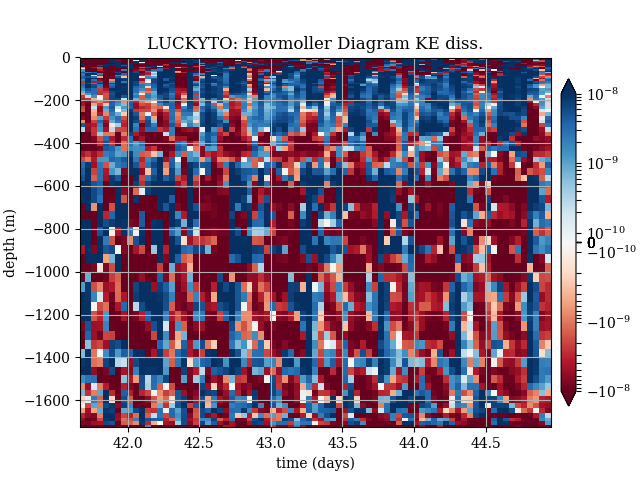

In [14]:
# Hovmoller diagram
ix, jy = 2, 2
damp = 1e-8
norm = mpl.colors.SymLogNorm(linthresh=1e-10, vmin=-damp, vmax=damp, linscale=.2)


plt.figure()
plt.pcolormesh(times.data/24,zrb[:,ix,jy], ked[:,:,ix,jy].T/dv_cell[:,j0,i0,None], cmap="RdBu", norm=norm)
plt.colorbar(extend="both", fraction=.03, pad=.02)

plt.title(simul.upper()+": Hovmoller Diagram KE diss.")
plt.xlabel('time (days)')
plt.ylabel('depth (m)')
plt.grid(True)

if False:
    plt.savefig('pictures/MomarPrep/{}_KEdiss_Hovmoller.png'.format(simul), magnification="auto", bbox_inches="tight", dpi=200)

<IPython.core.display.Javascript object>


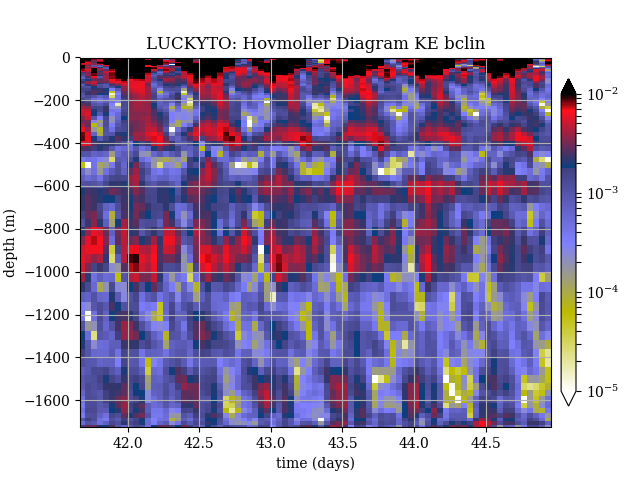

In [15]:
# kinetic energy
nc = Dataset(path_col, "r")
uu = nc.variables['u'][indt,...][:,:,jy,ix]
vv = nc.variables['v'][indt,...][:,:,jy,ix]
ubar = nc.variables['ubar'][indt,...][:,jy,ix]
vbar = nc.variables['vbar'][indt,...][:,jy,ix]
nc.close()
ke = .5*((uu-ubar[:,None])**2 + (vv-vbar[:,None])**2)
#del uu, vv, ubar, vbar
vamp = 1e-2
norm = mpl.colors.LogNorm(vmin=vamp/1e3, vmax=vamp)
cmap = "gist_stern_r"

plt.figure()
plt.pcolormesh(times.data/24,zrb[:,ix,jy], ke.T, cmap=cmap, norm=norm)
plt.colorbar(extend="both", fraction=.03, pad=.02)

plt.title(simul.upper()+": Hovmoller Diagram KE bclin")
plt.xlabel('time (days)')
plt.ylabel('depth (m)')
plt.grid(True)

if False:
    plt.savefig('pictures/MomarPrep/{}_KEbc_Hovmoller.png'.format(simul), magnification="auto", bbox_inches="tight", dpi=200)

<IPython.core.display.Javascript object>


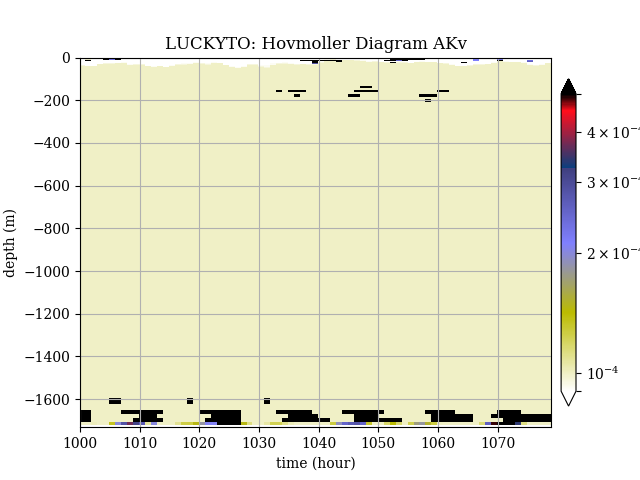

In [61]:
# AKv
nc = Dataset(path_col, "r")
Kv = nc.variables['AKv'][indt,...].mean(axis=(-2,-1))
#Kv = nc.variables['AKv'][indt,...][:,:,jy,ix]
zwb = nc.variables['zwb'][:][:,jy,ix]
nc.close()
vmin, vmax = 9e-5, 5e-4

norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap = "gist_stern_r"

plt.figure()
plt.pcolormesh(times.data,zwb, Kv.T, cmap=cmap, norm=norm)
plt.colorbar(extend="both", fraction=.03, pad=.02)

plt.title(simul.upper()+": Hovmoller Diagram AKv")
plt.xlabel('time (hour)')
plt.ylabel('depth (m)')
plt.grid(True)

if False:
    plt.savefig('pictures/MomarPrep/{}_AKv_Hovmoller.png'.format(simul), magnification="auto", bbox_inches="tight", dpi=200)

<IPython.core.display.Javascript object>


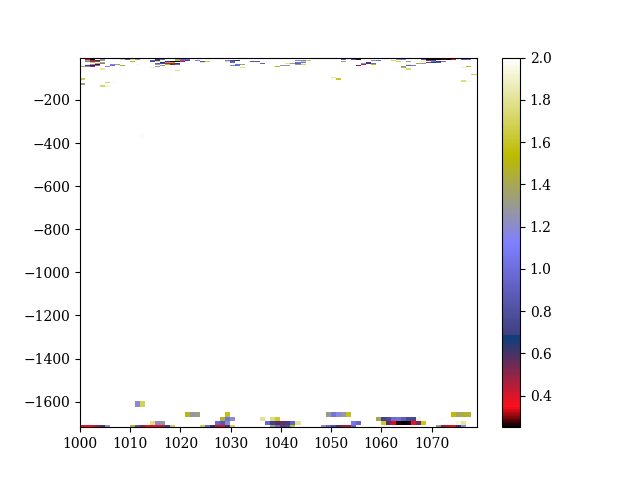

In [7]:
# vertical shear ?
cmap = "gist_stern"
jy, ix = 2, 2

nc = Dataset(path_col, "r")
ncvar = nc.variables
uu = ncvar['u'][indt,:,:,:][:,:,jy,ix]
vv = ncvar['v'][indt,:,:,:][:,:,jy,ix]
temp = ncvar['temp'][indt,:,:,:][:,:,jy,ix]
salt = ncvar['salt'][indt,:,:,:][:,:,jy,ix]
zwb = ncvar['zwb'][:][:,jy,ix]
zrb = ncvar['zrb'][:,][:,jy,ix]
nc.close()
dz = np.diff(zrb)

pres = gsw.p_from_z(zrb, lat.mean())
SA = gsw.SA_from_SP(salt, pres[None,:], lon.mean(), lat.mean())
CT = gsw.CT_from_pt(SA, temp)
bvf, pmid = gsw.Nsquared(SA, CT, pres, lat=lat.mean(), axis=-1)

shear = np.sqrt((np.diff(uu)/dz[None,:])**2 + (np.diff(uu)/dz[None,:])**2)
rich = bvf / shear**2

plt.figure()
plt.pcolormesh(times.data,zwb[1:-1], rich.T, cmap=cmap, vmin=1/4., vmax=2)
plt.colorbar()

In [49]:
np.where(times.mask)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),)

<IPython.core.display.Javascript object>


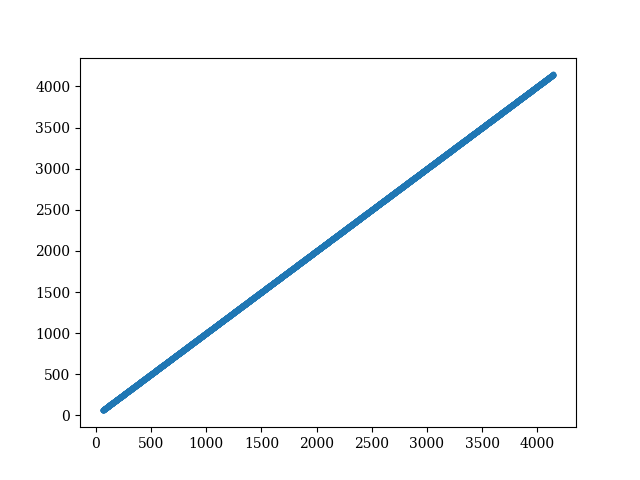

In [38]:
nc = Dataset(path_col, "r")
plt.figure()
plt.plot(nc.variables['time'][:], ".")

In [ ]:
# static stability?

nc = Dataset(path_col, "r")
ncvar = nc.variables
indt, = np.where(~ncvar['temp'][:,0,0,0].mask)
#uu = ncvar['u'][indt,:,:,:][:,:,jy,ix]
#vv = ncvar['v'][indt,:,:,:][:,:,jy,ix]
temp = ncvar['temp'][indt,...]
salt = ncvar['salt'][indt,...]
zwb = ncvar['zwb'][:].mean(axis=(-1,-2))
zrb = ncvar['zrb'][:]
times = ncvar['scrum_time'][indt]/3600/24
nc.close()
dz = np.diff(zrb)

pres = gsw.p_from_z(zrb, lat.mean())
SA = gsw.SA_from_SP(salt, pres[None,:], lon.mean(), lat.mean())
CT = gsw.CT_from_pt(SA, temp)
bvf, pmid = gsw.Nsquared(SA, CT, pres, lat=lat.mean(), axis=1)
bvf = bvf.mean(axis=(2,3))

<IPython.core.display.Javascript object>


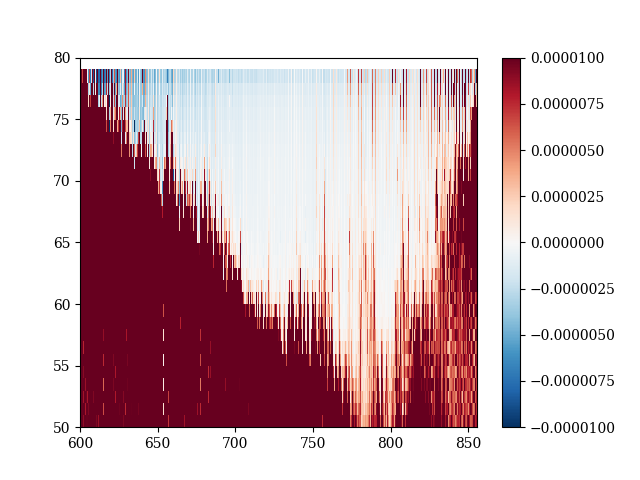

(50, 80)

In [66]:
cmap = "RdBu_r"
amp = 1e-5

plt.figure()
plt.pcolormesh(times,np.arange(1,80), bvf.T, cmap=cmap, vmin=-amp, vmax=amp)
plt.colorbar()
plt.ylim([50,80])

<IPython.core.display.Javascript object>


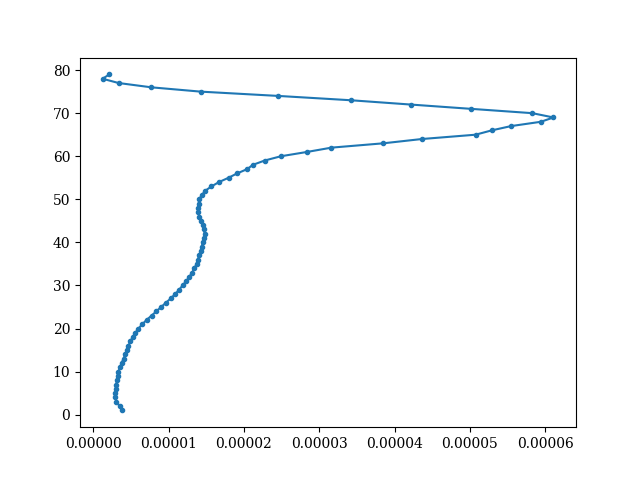

In [64]:
plt.figure()
plt.plot(bvf.mean(axis=0), np.arange(1,80), ".-")

<IPython.core.display.Javascript object>


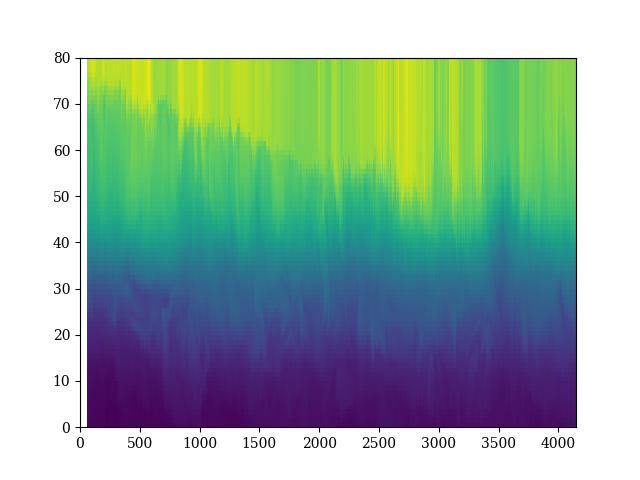

In [57]:
nc = Dataset(path_col, "r")
temp = nc.variables['salt'][:,:,2,0]

plt.figure()
plt.pcolormesh(temp.T)

In [39]:
bvf.shape

(4148, 79)

<IPython.core.display.Javascript object>


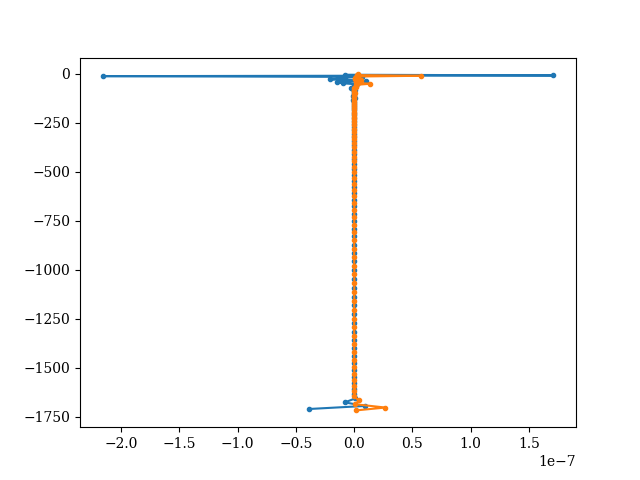

In [11]:
it = 40
plt.figure()
#plt.plot(ked[it,:,jy,ix], zrb[:,jy,ix], ".-")
dudz = np.diff(uu[it,:])/np.diff(zrb[:,jy,ix])
dvdz = np.diff(vv[it,:])/np.diff(zrb[:,jy,ix])
kzu = np.diff(Kv[it,1:-1]*dudz)/np.diff(zwb[1:-1])
kzv =  np.diff(Kv[it,1:-1]*dvdz)/np.diff(zwb[1:-1])
vmix = uu[it,1:-1]*kzu + vv[it,1:-1]*kzv
plt.plot(vmix, zrb[1:-1,jy,ix], '.-')

vdiss = Kv[it,1:-1] * (dudz**2 + dvdz**2)
plt.plot(vdiss, zwb[1:-1], '.-')

In [25]:
dir(gsw)

['CT_first_derivatives',
 'CT_first_derivatives_wrt_t_exact',
 'CT_freezing',
 'CT_freezing_first_derivatives',
 'CT_freezing_first_derivatives_poly',
 'CT_freezing_poly',
 'CT_from_enthalpy',
 'CT_from_enthalpy_exact',
 'CT_from_entropy',
 'CT_from_pt',
 'CT_from_rho',
 'CT_from_t',
 'CT_maxdensity',
 'CT_second_derivatives',
 'C_from_SP',
 'Fdelta',
 'Helmholtz_energy_ice',
 'Hill_ratio_at_SP2',
 'IPV_vs_fNsquared_ratio',
 'Nsquared',
 'SAAR',
 'SA_freezing_from_CT',
 'SA_freezing_from_CT_poly',
 'SA_freezing_from_t',
 'SA_freezing_from_t_poly',
 'SA_from_SP',
 'SA_from_SP_Baltic',
 'SA_from_Sstar',
 'SA_from_rho',
 'SP_from_C',
 'SP_from_SA',
 'SP_from_SA_Baltic',
 'SP_from_SK',
 'SP_from_SR',
 'SP_from_Sstar',
 'SR_from_SP',
 'Sstar_from_SA',
 'Sstar_from_SP',
 'Turner_Rsubrho',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_gsw_ufuncs',
 '_utilities',
 '_version',
 '_wrapped_ufuncs',